# Elo Merchant Category Recommendation - Ideas mentioned by others
End date: _2019. february 19._<br/>

This tutorial notebook is part of a series for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. LynxKite does not yet support some of the data preprocessing, thus they need to be done in Python. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import os
import gc
import time
import random
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

random.seed(1)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def create_date_features(df, source_column, preposition):
    df[preposition + '_year'] = df[source_column].dt.year
    df[preposition + '_month'] = df[source_column].dt.month
    df[preposition + '_day'] = df[source_column].dt.day
    df[preposition + '_hour'] = df[source_column].dt.hour
    df[preposition + '_weekofyear'] = df[source_column].dt.weekofyear
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    df[preposition + '_quarter'] = df[source_column].dt.quarter
    
    return df

## Minimal features
[Feature 1/2/3](https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/78839)

### Train and test data

In [4]:
df_train = pd.read_csv("input/train.csv", index_col="card_id")
df_train = reduce_mem_usage(df_train)

df_test = pd.read_csv("input/test.csv", index_col="card_id")
df_test = reduce_mem_usage(df_test)

print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))
print("{:,} records and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)
201,917 records and 5 features in train set.
123,623 records and 4 features in test set.


In [5]:
df_train['first_active_month'] = pd.to_datetime(df_train['first_active_month'])
df_train = create_date_features(df_train, 'first_active_month', 'fa')

In [6]:
df_test['first_active_month'] = pd.to_datetime(df_test['first_active_month'])
df_test = create_date_features(df_test, 'first_active_month', 'fa')

In [7]:
df_train[:3]

,first_active_month,feature_1,feature_2,feature_3,target,fa_year,fa_month,fa_day,fa_hour,fa_weekofyear,fa_dayofweek,fa_quarter
card_id,,,,,,,,,,,,
C_ID_92a2005557,2017-06-01,5,2,1,-0.820312,2017,6,1,0,22,3,2
C_ID_3d0044924f,2017-01-01,4,1,0,0.392822,2017,1,1,0,52,6,1
C_ID_d639edf6cd,2016-08-01,2,2,0,0.687988,2016,8,1,0,31,0,3


In [8]:
df_test[:3]

,first_active_month,feature_1,feature_2,feature_3,fa_year,fa_month,fa_day,fa_hour,fa_weekofyear,fa_dayofweek,fa_quarter
card_id,,,,,,,,,,,
C_ID_0ab67a22ab,2017-04-01,3,3,1,2017.0,4.0,1.0,0.0,13.0,5.0,2.0
C_ID_130fd0cbdd,2017-01-01,2,3,0,2017.0,1.0,1.0,0.0,52.0,6.0,1.0
C_ID_b709037bc5,2017-08-01,5,1,1,2017.0,8.0,1.0,0.0,31.0,1.0,3.0


### Transactions

In [9]:
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv", index_col="card_id", usecols=["card_id", "purchase_amount", "category_1", "category_2", "category_3", "installments"])
print("{:,} records and {} features in new transactions set.".format(df_new_trans.shape[0], df_new_trans.shape[1]))

df_new_trans = reduce_mem_usage(df_new_trans)

1,963,031 records and 5 features in new transactions set.
Starting memory usage: 89.86 MB
Reduced memory usage: 56.16 MB (37.5% reduction)


In [10]:
df_hist_trans = pd.read_csv("input/historical_transactions.csv", index_col="card_id", usecols=["card_id", "purchase_amount", "category_1", "category_2", "category_3", "installments"])
print("{:,} records and {} features in historical transactions set.".format(df_hist_trans.shape[0], df_hist_trans.shape[1]))

df_hist_trans = reduce_mem_usage(df_hist_trans)

29,112,361 records and 5 features in historical transactions set.
Starting memory usage: 1332.66 MB
Reduced memory usage: 888.44 MB (33.3% reduction)


In [11]:
#df_hist_trans['authorized_flag'] = df_hist_trans['authorized_flag'].map({'N': 0, 'Y': 1})
df_hist_trans['category_1'] = df_hist_trans['category_1'].map({'N': 0, 'Y': 1})
df_hist_trans['category_2'] = pd.to_numeric(df_hist_trans['category_2'])
df_hist_trans['category_3'] = df_hist_trans['category_3'].map({'A': 0, 'B': 1, 'C': 2})

In [12]:
#df_new_trans['authorized_flag'] = df_new_trans['authorized_flag'].map({'N': 0, 'Y': 1})
df_new_trans['category_1'] = df_new_trans['category_1'].map({'N': 0, 'Y': 1})
df_new_trans['category_2'] = pd.to_numeric(df_new_trans['category_2'])
df_new_trans['category_3'] = df_new_trans['category_3'].map({'A': 0, 'B': 1, 'C': 2})

#### Aggregation

In [13]:
def aggregate_transactions(df, prefix):  
    agg_funcs = {
        'category_1': ['sum', 'mean'],
        'category_2': ['sum', 'mean'],
        'category_3': ['sum', 'mean'],
        
        'installments': ['sum', 'median', 'mean', 'max', 'min', 'std'],
        
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std']
    }
    df_agg = df.groupby('card_id').agg(agg_funcs)
    df_agg.columns = [prefix + '_'.join(col).strip() for col in df_agg.columns.values]
    df_agg.reset_index(inplace=True)

    df = (df_agg.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))
    df_agg = pd.merge(df, df_agg, on='card_id', how='left')

    return df_agg

In [14]:
df_new_trans = aggregate_transactions(df_new_trans, prefix='new_')

In [15]:
df_hist_trans = aggregate_transactions(df_hist_trans, prefix='hist_')

In [16]:
df_new_trans.shape, df_hist_trans.shape

((290001, 19), (325540, 19))

In [17]:
df_new_trans[:3]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_sum,new_category_2_mean,new_category_3_sum,new_category_3_mean,new_installments_sum,new_installments_median,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std
0,C_ID_00007093c1,1,0,0.000000,4.0,2.000000,2.0,1.00,2,1.0,1.000000,1,1,0.000000,-1.328125,-0.664062,-0.656738,-0.671875,0.010704
1,C_ID_0001238066,1,2,0.076923,35.0,1.521484,29.0,1.16,42,1.0,1.615385,10,-1,2.079941,-14.851562,-0.571289,-0.078308,-0.740723,0.173462
2,C_ID_0001506ef0,1,0,0.000000,6.0,3.000000,0.0,0.00,0,0.0,0.000000,0,0,0.000000,-1.447266,-0.723633,-0.715332,-0.731934,0.011742


In [18]:
df_hist_trans[:3]

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_sum,hist_category_2_mean,hist_category_3_sum,hist_category_3_mean,hist_installments_sum,hist_installments_median,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std
0,C_ID_00007093c1,1,28,0.187919,365.0,3.015625,173.0,1.161074,192,1.0,1.288591,6,1,0.764900,-76.845039,-0.515739,1.507069,-0.728876,0.298141
1,C_ID_0001238066,1,2,0.016260,195.0,1.695312,152.0,1.266667,198,1.0,1.609756,10,-1,1.485637,-72.447197,-0.589002,0.768095,-0.734887,0.190235
2,C_ID_0001506ef0,1,0,0.000000,194.0,2.939453,1.0,0.015152,1,0.0,0.015152,1,0,0.123091,-34.601879,-0.524271,1.493545,-0.740491,0.472284


### Merging

In [19]:
%%time
df_train = pd.merge(df_train, df_hist_trans, on='card_id', how='left')
df_train = pd.merge(df_train, df_new_trans, on='card_id', how='left')

Wall time: 688 ms


In [20]:
%%time
df_test = pd.merge(df_test, df_hist_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_new_trans, on='card_id', how='left')

Wall time: 508 ms


In [21]:
df_train.set_index("card_id", inplace=True)
df_test.set_index("card_id", inplace=True)

In [22]:
del df_hist_trans
del df_new_trans
gc.collect()

161

In [23]:
df_train[:3]

,first_active_month,feature_1,feature_2,feature_3,target,fa_year,fa_month,fa_day,fa_hour,fa_weekofyear,...,new_installments_median,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_92a2005557,2017-06-01,5,2,1,-0.820312,2017,6,1,0,22,...,0.0,0.0,0.0,0.0,0.0,-13.242188,-0.575684,-0.296143,-0.724609,0.135742
C_ID_3d0044924f,2017-01-01,4,1,0,0.392822,2017,1,1,0,52,...,1.0,1.0,1.0,1.0,0.0,-4.355469,-0.726074,-0.701660,-0.739258,0.014381
C_ID_d639edf6cd,2016-08-01,2,2,0,0.687988,2016,8,1,0,31,...,0.0,0.0,0.0,0.0,NaN,-0.700195,-0.700195,-0.700195,-0.700195,NaN


In [24]:
df_test[:3]

,first_active_month,feature_1,feature_2,feature_3,fa_year,fa_month,fa_day,fa_hour,fa_weekofyear,fa_dayofweek,...,new_installments_median,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_0ab67a22ab,2017-04-01,3,3,1,2017.0,4.0,1.0,0.0,13.0,5.0,...,1.0,1.666667,3.0,1.0,1.154701,-1.777344,-0.592285,-0.383301,-0.722168,0.182861
C_ID_130fd0cbdd,2017-01-01,2,3,0,2017.0,1.0,1.0,0.0,52.0,6.0,...,1.0,1.222222,3.0,1.0,0.666667,-5.945312,-0.660645,-0.506348,-0.740723,0.071167
C_ID_b709037bc5,2017-08-01,5,1,1,2017.0,8.0,1.0,0.0,31.0,1.0,...,5.5,5.500000,10.0,1.0,6.363961,0.179688,0.089844,0.904297,-0.724609,1.152344


### Training

In [25]:
target = df_train['target']
features = [c for c in df_train.columns if c not in ['first_active_month', 'target']]

In [26]:
param = {
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_seed": 11,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "lambda_l1": 0.1,
    'learning_rate': 0.005,
    'max_depth': -1,
    "metric": 'rmse',
    "min_child_weight": 0.01,
    'min_data_in_leaf': 30, 
    'num_leaves': 50,
    'objective':'regression',
    "seed": 1,
    "verbosity": -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof = np.zeros(len(df_train[features]))
predictions = np.zeros(len(df_test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print("\nFold {}.".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits


Fold 1.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.79674	valid_1's rmse: 3.85416
[200]	training's rmse: 3.76637	valid_1's rmse: 3.83958
[300]	training's rmse: 3.74297	valid_1's rmse: 3.83144
[400]	training's rmse: 3.72294	valid_1's rmse: 3.82671
[500]	training's rmse: 3.70534	valid_1's rmse: 3.82356
[600]	training's rmse: 3.68928	valid_1's rmse: 3.82152
[700]	training's rmse: 3.67514	valid_1's rmse: 3.82008
[800]	training's rmse: 3.66224	valid_1's rmse: 3.81873
[900]	training's rmse: 3.65024	valid_1's rmse: 3.81822
[1000]	training's rmse: 3.63894	valid_1's rmse: 3.8179
[1100]	training's rmse: 3.62816	valid_1's rmse: 3.8174
[1200]	training's rmse: 3.618	valid_1's rmse: 3.81742
Early stopping, best iteration is:
[1105]	training's rmse: 3.62764	valid_1's rmse: 3.81735

Fold 2.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.81504	valid_1's rmse: 3.77791
[200]	training's rmse: 3.78443	valid_1's rmse: 3.76

In [27]:
cross_validation_lgb = np.sqrt(mean_squared_error(target, oof))
print('Cross-validation score: ' + str(cross_validation_lgb))

Cross-validation score: 3.790658746258206


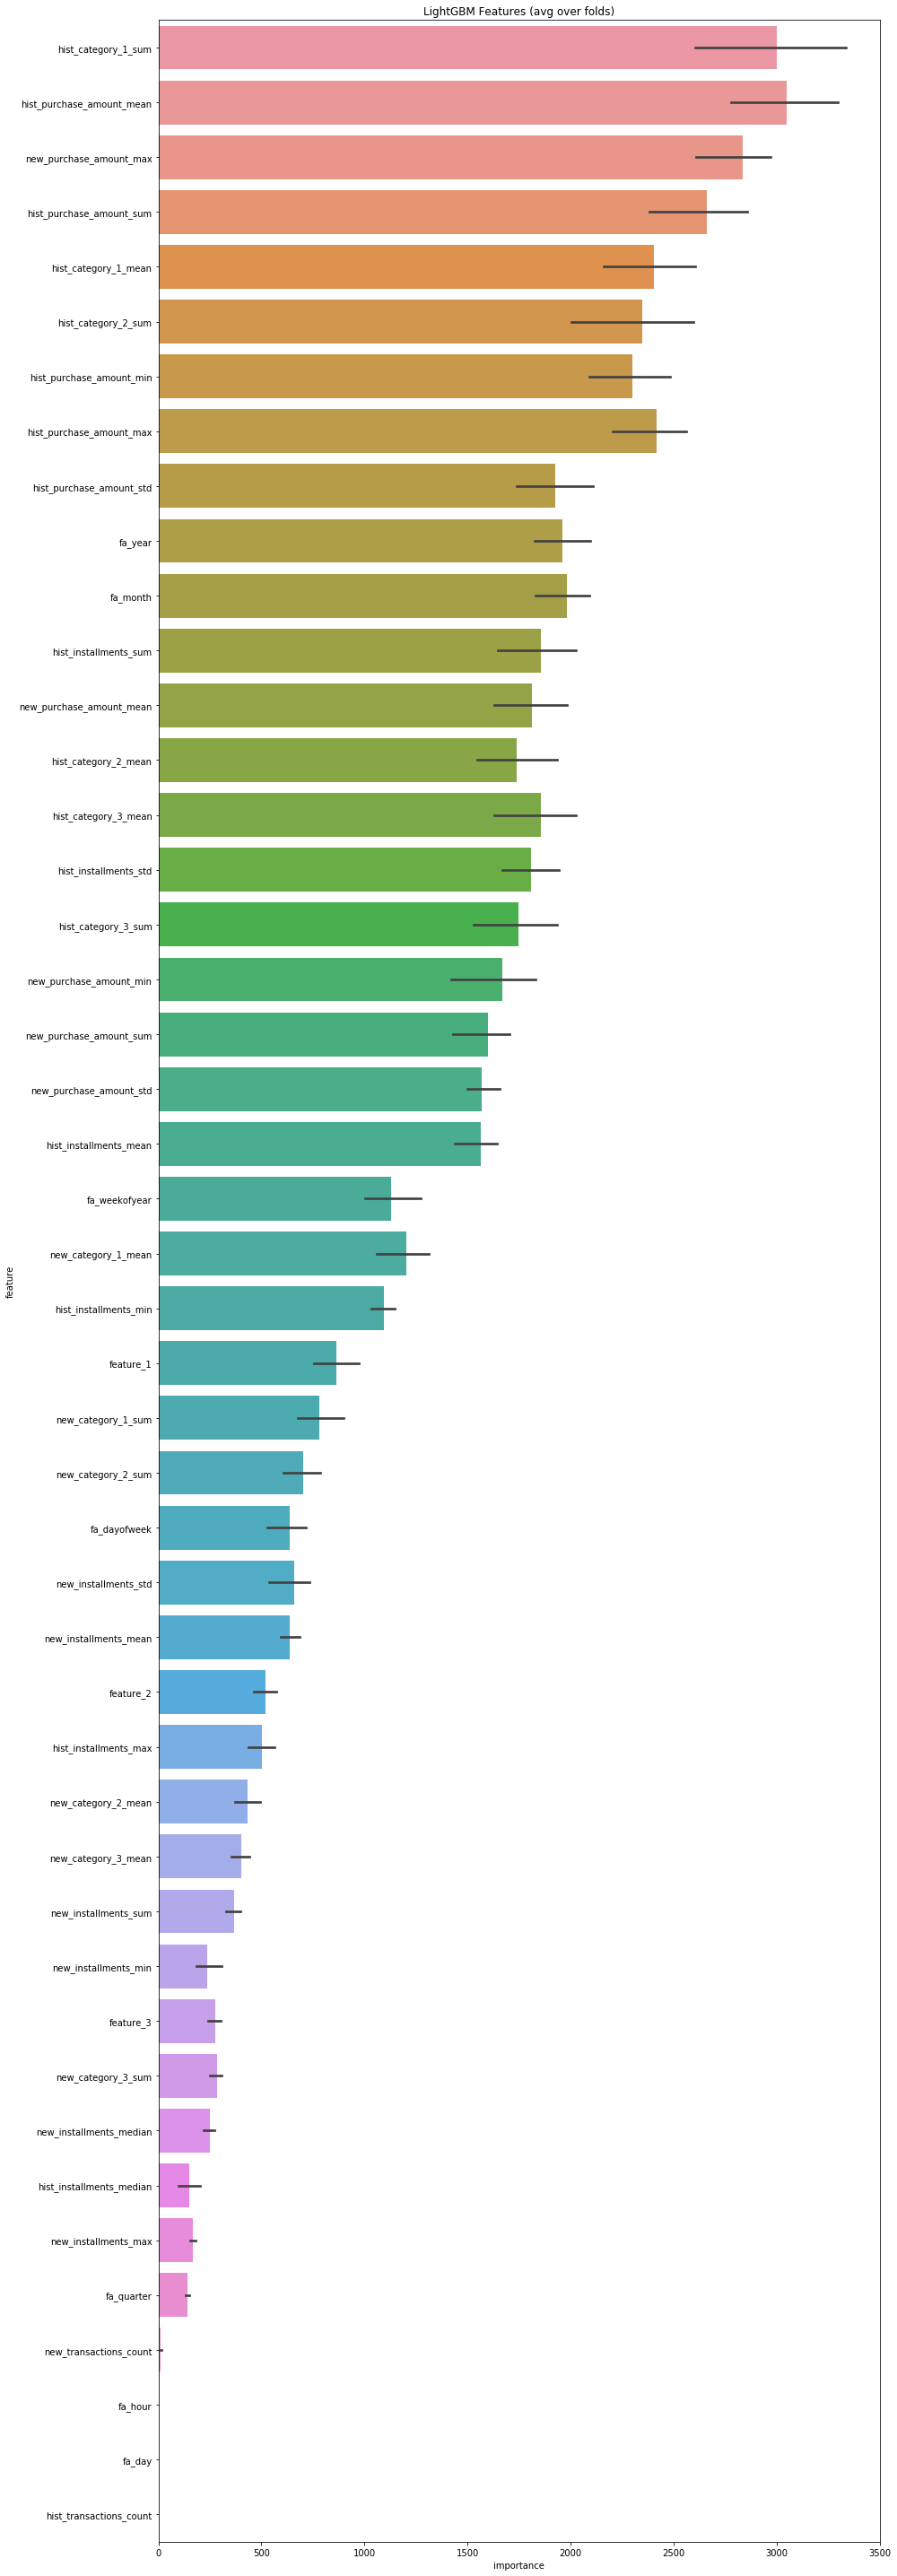

In [28]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(cols)]

plt.figure(figsize=(14, 40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [29]:
clf.save_model('models/regression_konstantin_yakovlev.txt')

In [30]:
df_sub = pd.DataFrame({
    "card_id": df_test.index
})

df_sub["target"] = predictions
df_sub.to_csv("output/regression_{}.csv".format(cross_validation_lgb), index=False)

## Play-Kaggle
[Feature engineering](https://github.com/zzsza/Play-Kaggle/blob/master/Elo-Merchant-Category-Recommendation/notebooks/03.Feature-Engineering.ipynb)

In [31]:
%%time
new_transactions = pd.read_csv('input/new_merchant_transactions.csv', parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('input/historical_transactions.csv', parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

Wall time: 2min 38s


In [32]:
%%time
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

train = read_data('input/train.csv')
test = read_data('input/test.csv')

target = train['target']
del train['target']

Wall time: 1.81 s


### Feature engineering

In [33]:
historical_transactions['month_diff'] = ((datetime.datetime.today() - historical_transactions['purchase_date']).dt.days)//30

In [34]:
historical_transactions['month_diff'] += historical_transactions['month_lag']

In [35]:
new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

In [36]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

Starting memory usage: 3109.54 MB
Reduced memory usage: 1332.66 MB (57.1% reduction)
Starting memory usage: 209.67 MB
Reduced memory usage: 86.12 MB (58.9% reduction)


In [37]:
agg_fun = {'authorized_flag': ['mean']}

In [38]:
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)

In [39]:
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]

In [40]:
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

In [41]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [42]:
%%time
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

Wall time: 0 ns


In [43]:
%%time
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]

Wall time: 28.2 s


In [44]:
history[:5]

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,...,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean
0,C_ID_00007093c1,35,4.0,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,...,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-6.028571,0,-11,3.535415,12.028571
1,C_ID_0001238066,3,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,...,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-1.333333,0,-2,1.154701,12.000000
2,C_ID_0001506ef0,4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,...,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-2.500000,0,-8,3.785939,12.000000
3,C_ID_0001793786,27,2.0,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,...,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-3.518519,-1,-7,2.375684,16.148148
4,C_ID_000183fdda,7,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,...,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-5.714286,-4,-6,0.755929,12.000000


In [45]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]

In [46]:
authorized[:5]

,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,...,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean
0,C_ID_00007093c1,114,24.0,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.0,...,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-5.798246,0,-12,3.441495,12.052632
1,C_ID_0001238066,120,2.0,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.0,...,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-1.825000,0,-5,1.294218,11.991667
2,C_ID_0001506ef0,62,0.0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.0,...,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-4.983871,0,-13,4.248402,12.032258
3,C_ID_0001793786,189,0.0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.0,...,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-3.301587,0,-9,2.301491,16.095238
4,C_ID_000183fdda,137,4.0,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.0,...,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-2.284672,0,-5,1.782055,11.978102


In [47]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]

In [48]:
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,...,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,...,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2.000000,2,2,0.000000,12.000000
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,...,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1.346154,2,1,0.485165,11.961538
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,...,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1.000000,1,1,0.000000,12.000000
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,...,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1.322581,2,1,0.475191,15.870968
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,...,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1.272727,2,1,0.467099,11.909091


In [49]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(authorized_transactions) 
final_group[:10]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,...,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,8.769231,3.539158,-4.803313,2.175011,-0.536131,0.075418,-0.702649,...,11.307692,4.210792,1.369646,0.423190,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,-2.500000,1.870829,20.000000,11.696153,-11.776212,6.676914,-0.603215,0.046045,-0.730351,...,32.500000,24.501020,1.652873,0.410539,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,-6.230769,4.225988,4.769231,4.342692,-2.438161,2.902502,-0.446660,0.271125,-0.725724,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,C_ID_0001793786,-4.500000,3.027650,18.900000,12.160501,-2.496067,4.018810,-0.005687,0.271221,-0.646277,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,C_ID_000183fdda,-2.500000,1.870829,22.833333,7.167054,-11.316092,4.800612,-0.489227,0.141015,-0.728405,...,40.833333,14.048725,1.834943,0.362557,0.333333,1.032796,9.166667,2.041241,2.144389,0.665529
5,C_ID_00024e244b,-6.384615,4.330867,4.076923,4.290717,-2.557395,2.089708,-0.685118,0.071894,-0.728885,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,C_ID_0002709b5a,-5.000000,3.316625,6.090909,3.505839,-3.994622,2.440540,-0.638637,0.060836,-0.700104,...,10.727273,8.427229,1.965729,1.287108,0.818182,0.603023,3.818182,3.341203,1.600058,1.734256
7,C_ID_00027503e2,-4.000000,2.738613,2.666667,1.224745,-1.974976,0.909524,-0.740077,0.002424,-0.742206,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-5.250000,4.334249,3.500000,1.772811,-1.844563,0.699127,-0.590214,0.168008,-0.686623,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,C_ID_0002ba3c2e,-4.666667,3.141125,9.166667,4.665476,-5.843051,3.021165,-0.638037,0.044976,-0.721448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [50]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [51]:
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')

### Train

In [52]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

In [53]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
#features = [f for f in features if f not in unimportant_features]
categorical_feats = ['feature_2', 'feature_3']

In [54]:
param = {
    'num_leaves': 111,
     'min_data_in_leaf': 149, 
     'objective':'regression',
     'max_depth': 9,
     'learning_rate': 0.005,
     "boosting": "gbdt",
     "feature_fraction": 0.7522,
     "bagging_freq": 1,
     "bagging_fraction": 0.7083 ,
     "bagging_seed": 11,
     "metric": 'rmse',
     "lambda_l1": 0.2634,
     "random_state": 133,
     "verbosity": -1
}

In [55]:
%%time
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71478	valid_1's rmse: 3.77637
[200]	training's rmse: 3.645	valid_1's rmse: 3.72834
[300]	training's rmse: 3.60176	valid_1's rmse: 3.70482
[400]	training's rmse: 3.5701	valid_1's rmse: 3.6929
[500]	training's rmse: 3.54669	valid_1's rmse: 3.68624
[600]	training's rmse: 3.52753	valid_1's rmse: 3.68168
[700]	training's rmse: 3.51115	valid_1's rmse: 3.6784
[800]	training's rmse: 3.49701	valid_1's rmse: 3.67675
[900]	training's rmse: 3.48433	valid_1's rmse: 3.67563
[1000]	training's rmse: 3.47255	valid_1's rmse: 3.67504
[1100]	training's rmse: 3.4607	valid_1's rmse: 3.67394
[1200]	training's rmse: 3.44922	valid_1's rmse: 3.67323
[1300]	training's rmse: 3.43799	valid_1's rmse: 3.67266
[1400]	training's rmse: 3.42784	valid_1's rmse: 3.6724
[1500]	training's rmse: 3.41779	valid_1's rmse: 3.67188
[1600]	training's rmse: 3.40802	valid_1's rmse: 3.67183
[1700]	training's rmse: 3.39785	valid_1's rmse: 

In [56]:
cv_score = mean_squared_error(oof, target)**0.5
print("CV score: {:<8.5f}".format(cv_score))

CV score: 3.65556 


### Feature importance

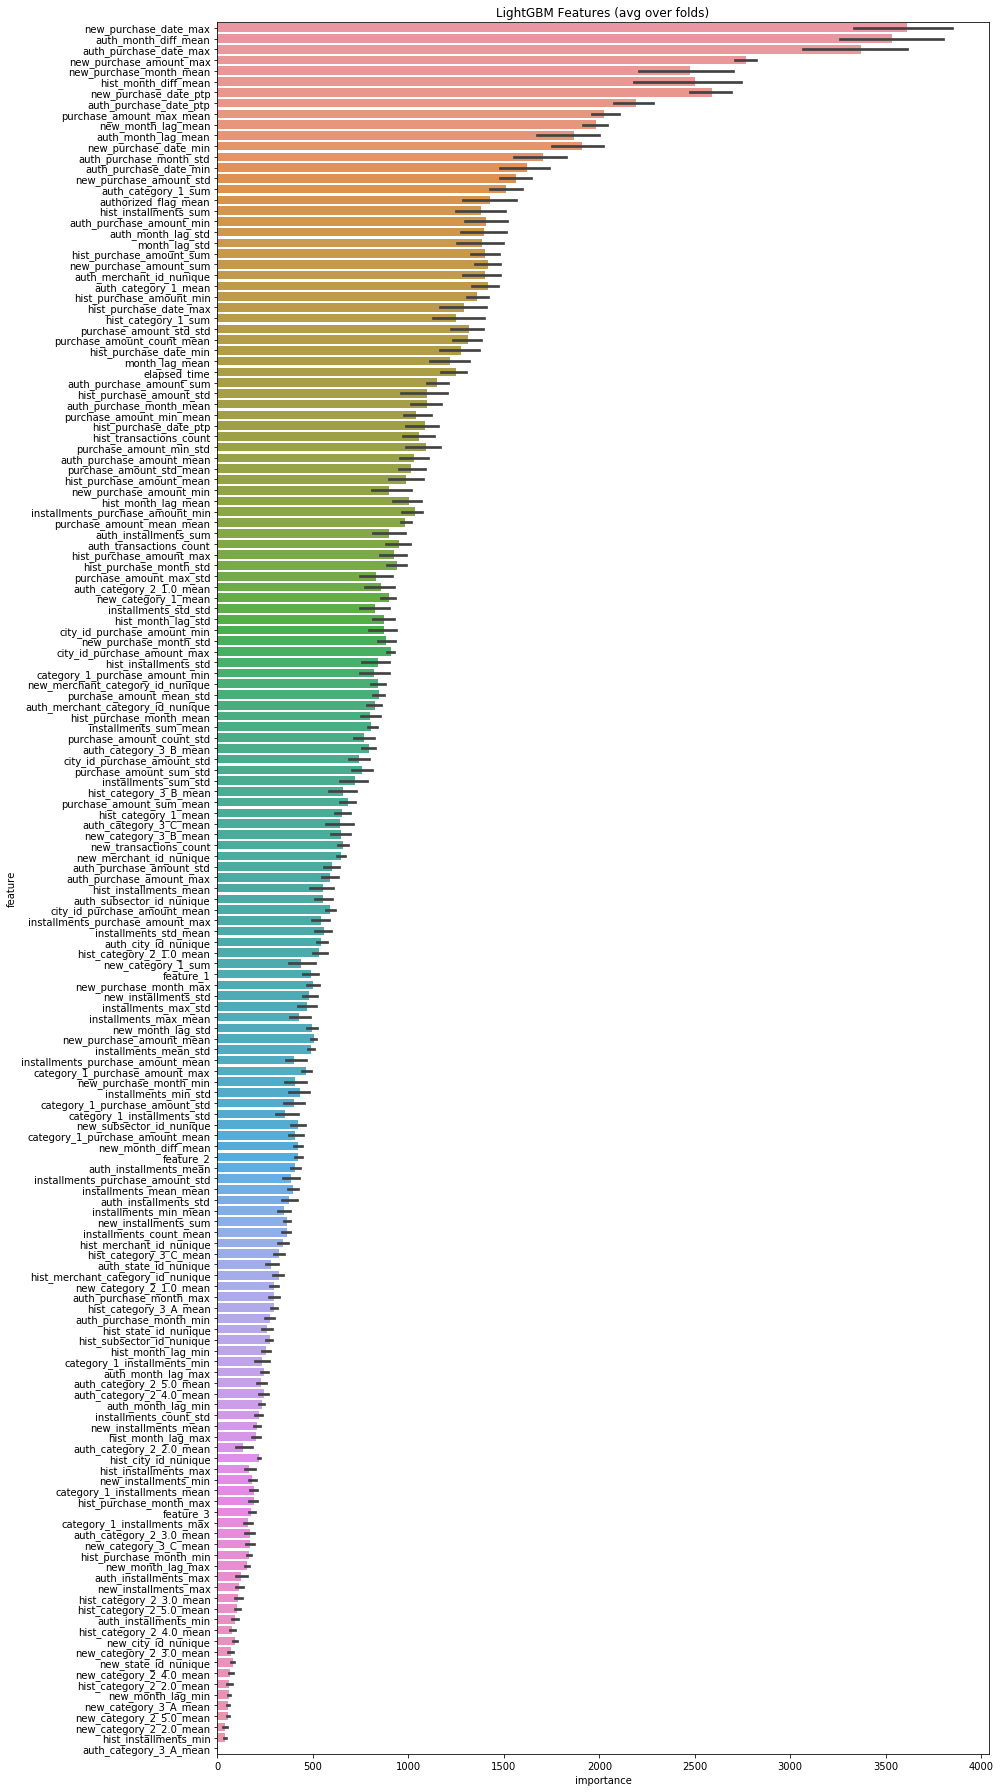

In [57]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [58]:
sub_df = pd.DataFrame({
    "card_id": test["card_id"].values
})

sub_df["target"] = predictions
sub_df.to_csv("output/regression_{:.6f}.csv".format(cv_score), index=False)

## Feature engineering
[Feature Engineering](https://github.com/zzsza/Play-Kaggle/blob/master/Elo-Merchant-Category-Recommendation/notebooks/04.Feature-Engineering_2nd.ipynb)

In [59]:
import gc
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings('ignore')
np.random.seed(402)

In [60]:
%%time
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)
Wall time: 831 ms


In [61]:
%%time
df_hist_trans = pd.read_csv('input/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('input/new_merchant_transactions.csv')

df_hist_trans = reduce_mem_usage(df_hist_trans)
df_new_merchant_trans = reduce_mem_usage(df_new_merchant_trans)

Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.7% reduction)
Starting memory usage: 209.67 MB
Reduced memory usage: 114.20 MB (45.5% reduction)
Wall time: 3min


In [62]:
for df in [df_hist_trans, df_new_merchant_trans]:
    df['category_2'].fillna(1.0, inplace=True)
    df['category_3'].fillna('A', inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)

What happens if we remove the missing data?

In [63]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [64]:
%%time
for df in [df_hist_trans, df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

Wall time: 1min 1s


In [65]:
%%time
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist', aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id', how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id', how='left')
del df_hist_trans_group;gc.collect()

Wall time: 1min 45s


Create a separate function, put params into an array

In [66]:
%%time
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2', 'category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

Wall time: 9.97 s


In [67]:
del df_hist_trans
gc.collect()

del df_new_merchant_trans
gc.collect()

df_train[:5]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,9,23,35,7,...,6.0,0.260870,0.0,0.000000,23.0,-0.550293,-0.592773,54.0,2.347826,300.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,12,24,50,7,...,0.0,0.000000,0.0,0.000000,6.0,-0.550293,-0.606445,56.0,9.333333,330.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,10,14,22,7,...,1.0,1.000000,0.0,0.000000,1.0,-0.548828,-0.592773,0.0,0.000000,301.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142456,6,16,20,7,...,3.0,0.428571,1.0,0.142857,7.0,-0.556641,-0.604492,41.0,5.857143,311.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159790,4,22,17,7,...,12.0,0.333333,2.0,0.055556,36.0,-0.555664,-0.588379,57.0,1.583333,301.0


In [68]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [69]:
%%time
for df in [df_train, df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max', 'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1', 'feature_2', 'feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

Wall time: 652 ms


In [70]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = df_train['target']
del df_train['target']

In [71]:
%%time
param = {
    'num_leaves': 31,
    'min_data_in_leaf': 30, 
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.01,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1, 
    "verbosity": -1,
    "nthread": -1,
    "random_state": 402
}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=402)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, df_train['outliers'].values)):
    print("\nFold {}.".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits


Fold 0.
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.66515	valid_1's rmse: 3.72197
[200]	training's rmse: 3.58912	valid_1's rmse: 3.68923
[300]	training's rmse: 3.54225	valid_1's rmse: 3.67629
[400]	training's rmse: 3.50645	valid_1's rmse: 3.66902
[500]	training's rmse: 3.4762	valid_1's rmse: 3.66363
[600]	training's rmse: 3.45119	valid_1's rmse: 3.66004
[700]	training's rmse: 3.42777	valid_1's rmse: 3.6578
[800]	training's rmse: 3.40662	valid_1's rmse: 3.65626
[900]	training's rmse: 3.38785	valid_1's rmse: 3.65478
[1000]	training's rmse: 3.36937	valid_1's rmse: 3.65429
[1100]	training's rmse: 3.35251	valid_1's rmse: 3.65354
[1200]	training's rmse: 3.33644	valid_1's rmse: 3.65334
[1300]	training's rmse: 3.32174	valid_1's rmse: 3.65318
[1400]	training's rmse: 3.30638	valid_1's rmse: 3.65292
[1500]	training's rmse: 3.29153	valid_1's rmse: 3.65238
[1600]	training's rmse: 3.27765	valid_1's rmse: 3.65226
[1700]	training's rmse: 3.26318	valid_1's r

In [72]:
cv_score = np.sqrt(mean_squared_error(oof, target))
print("CV score: {:.6f}".format(cv_score))

CV score: 3.653023


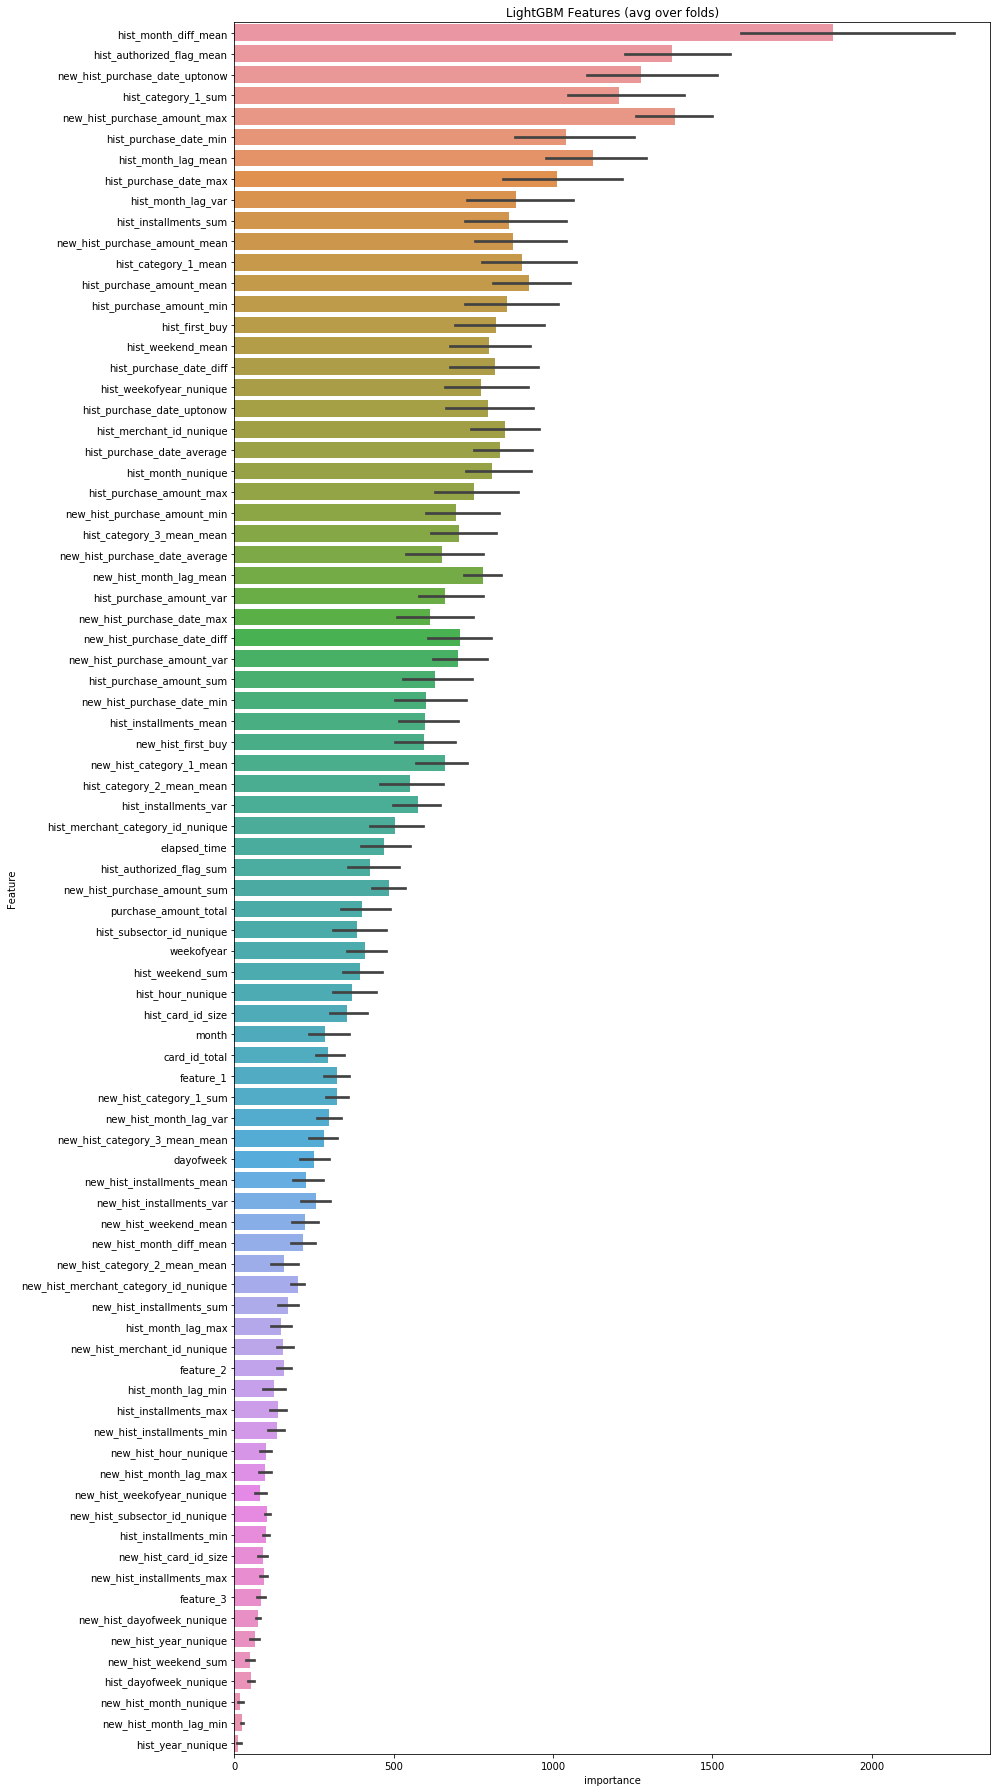

In [73]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance", y="Feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [74]:
sub_df = pd.DataFrame({
    "card_id": df_test["card_id"].values
})

sub_df["target"] = predictions
sub_df.to_csv("output/regression_{:.6f}.csv".format(cv_score), index=False)

[Just Train Data - LGB & XGB & CatBoost w/ Blending](https://www.kaggle.com/silverstone1903/just-train-data-lgb-xgb-catboost-w-blending/data)<br/>
[MultiModel + RIDGE + STACKING](https://www.kaggle.com/ashishpatel26/rmse-3-66-multimodel-ridge-stacking)

## Train the last algorithm only on inliers and use classification result to modify the prediction
## for those test cases which are predicted to be outliers with high probability

In [75]:
df_train['outliers'].unique()

array([0, 1], dtype=int64)

In [76]:
df_train['outliers'].sum()

2207

In [77]:
df_train.shape

(201917, 86)

In [78]:
df_train_inliers = df_train.loc[df_train['outliers'] == 0].copy()
df_train_inliers.shape

(199710, 86)

In [79]:
target_inliers = target[df_train['outliers'] == 0]
target_inliers.shape

(199710,)

In [80]:
df_train_inliers.reset_index(drop = True, inplace = True)

In [81]:
target_inliers.reset_index(drop = True, inplace = True)

In [82]:
%%time
param = {
    'num_leaves': 31,
    'min_data_in_leaf': 30, 
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.01,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1, 
    "verbosity": -1,
    "nthread": -1,
    "random_state": 402
}
folds = KFold(n_splits=5, shuffle=True, random_state=402)
oof = np.zeros(len(df_train_inliers))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train_inliers)):
    print("\nFold {}.".format(fold_))
    trn_data = lgb.Dataset(df_train_inliers.iloc[trn_idx][df_train_columns], label=target_inliers.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train_inliers.iloc[val_idx][df_train_columns], label=target_inliers.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(df_train_inliers.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits


Fold 0.
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 1.60795	valid_1's rmse: 1.61121
[200]	training's rmse: 1.57692	valid_1's rmse: 1.58258
[300]	training's rmse: 1.56212	valid_1's rmse: 1.57089
[400]	training's rmse: 1.55232	valid_1's rmse: 1.56433
[500]	training's rmse: 1.54487	valid_1's rmse: 1.56058
[600]	training's rmse: 1.53874	valid_1's rmse: 1.55811
[700]	training's rmse: 1.53339	valid_1's rmse: 1.55648
[800]	training's rmse: 1.52857	valid_1's rmse: 1.55548
[900]	training's rmse: 1.52418	valid_1's rmse: 1.55475
[1000]	training's rmse: 1.52012	valid_1's rmse: 1.55415
[1100]	training's rmse: 1.51625	valid_1's rmse: 1.55373
[1200]	training's rmse: 1.51255	valid_1's rmse: 1.55334
[1300]	training's rmse: 1.509	valid_1's rmse: 1.55304
[1400]	training's rmse: 1.50552	valid_1's rmse: 1.55293
[1500]	training's rmse: 1.50217	valid_1's rmse: 1.55279
[1600]	training's rmse: 1.49887	valid_1's rmse: 1.55256
[1700]	training's rmse: 1.49553	valid_1's r

[900]	training's rmse: 1.52318	valid_1's rmse: 1.55684
[1000]	training's rmse: 1.51918	valid_1's rmse: 1.5565
[1100]	training's rmse: 1.51538	valid_1's rmse: 1.55618
[1200]	training's rmse: 1.51168	valid_1's rmse: 1.55593
[1300]	training's rmse: 1.50811	valid_1's rmse: 1.55578
[1400]	training's rmse: 1.50468	valid_1's rmse: 1.55565
[1500]	training's rmse: 1.50128	valid_1's rmse: 1.55554
[1600]	training's rmse: 1.49794	valid_1's rmse: 1.55546
[1700]	training's rmse: 1.49468	valid_1's rmse: 1.5553
[1800]	training's rmse: 1.49148	valid_1's rmse: 1.5552
[1900]	training's rmse: 1.4883	valid_1's rmse: 1.5551
[2000]	training's rmse: 1.48513	valid_1's rmse: 1.55497
[2100]	training's rmse: 1.48199	valid_1's rmse: 1.55484
[2200]	training's rmse: 1.47897	valid_1's rmse: 1.55486
[2300]	training's rmse: 1.47589	valid_1's rmse: 1.55481
[2400]	training's rmse: 1.4729	valid_1's rmse: 1.55471
[2500]	training's rmse: 1.46988	valid_1's rmse: 1.55476
Early stopping, best iteration is:
[2396]	training's rm

In [83]:
cv_score = np.sqrt(mean_squared_error(oof, target_inliers))
print("CV score: {:.6f}".format(cv_score))

CV score: 1.555492


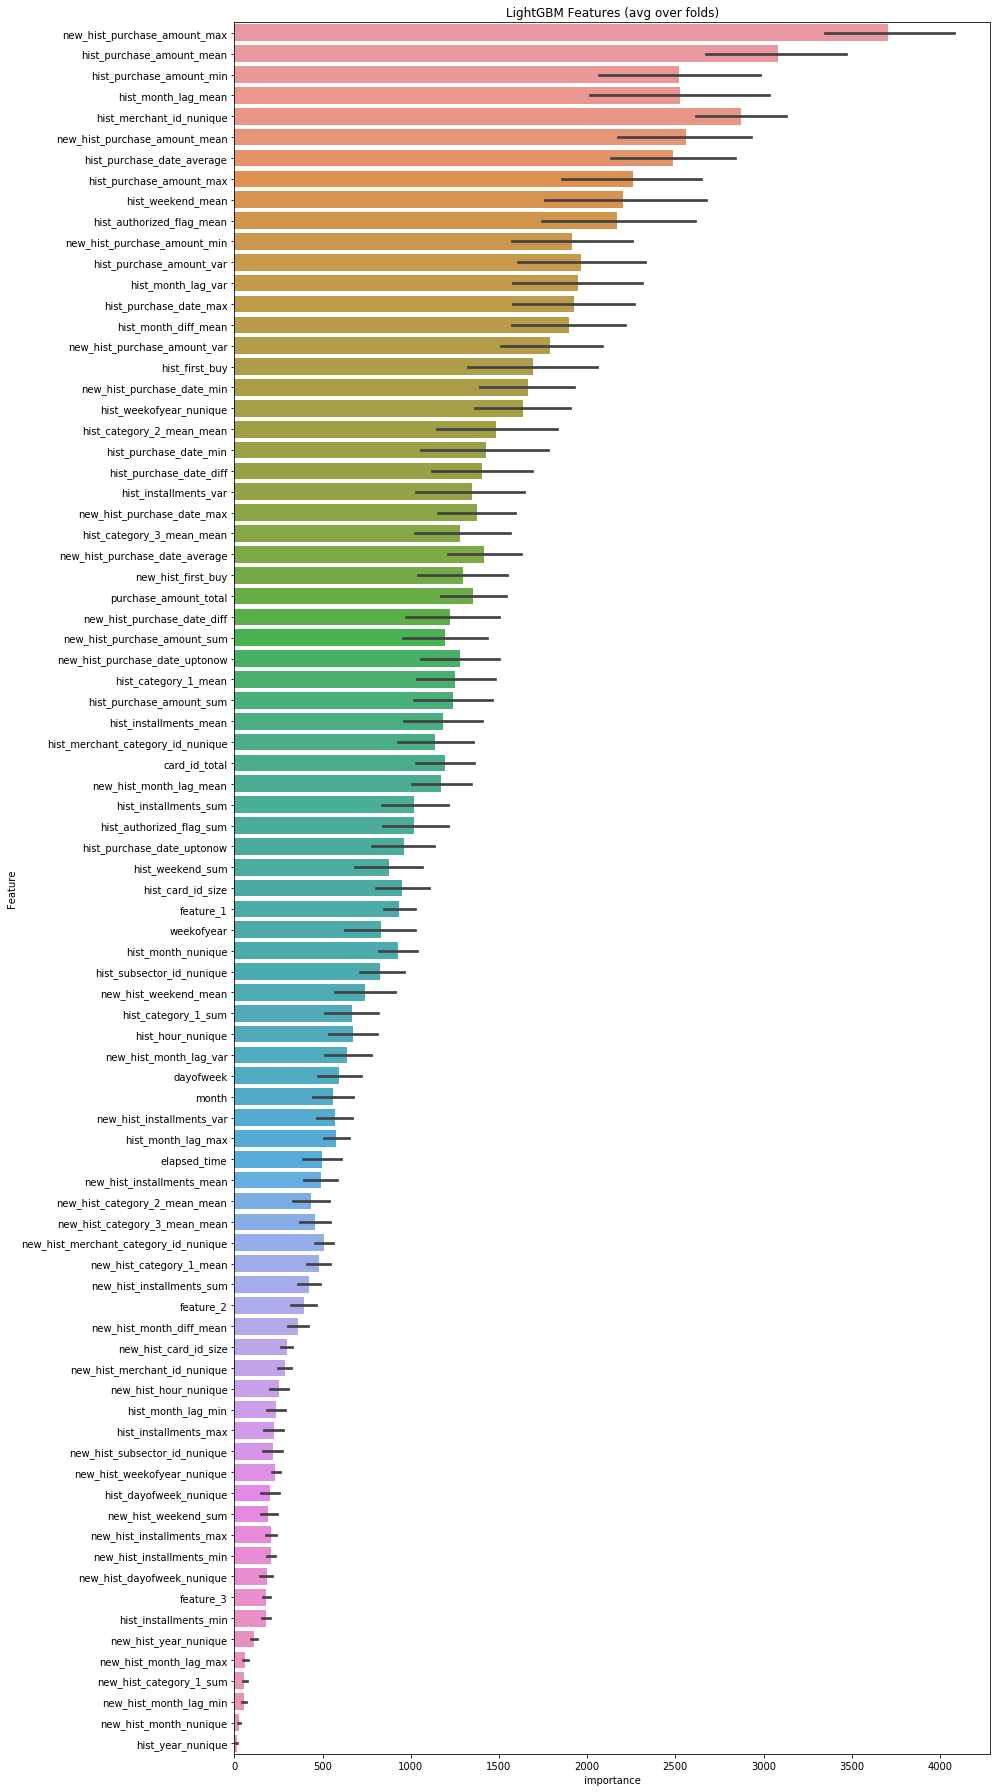

In [84]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance", y="Feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [85]:
sub_df2 = pd.DataFrame({
    "card_id": df_test["card_id"].values
})

sub_df2["target"] = predictions
sub_df2.to_csv('C:/Users/judit/Documents/learning/kaggle/Elo_201812/submissions/submit_others_3_11_190223_{:.6f}.csv'.format(\
    cv_score), index=False)

### Modify prediction for test examples predicted to be outliers

In [86]:
new_submission = sub_df2.copy()
pred_outlier = pd.read_csv('C:/Users/judit/Documents/learning/kaggle/Elo_201812/submissions/submit_190131_0.csv')

new_submission['is_outlier'] = pred_outlier['target']
new_submission['new_target'] = new_submission.apply(lambda row : row['target'] if row['is_outlier'] == 0 else
                                                                 (0.9 * (row['target'] - 33.219281) / 2), axis = 1)
new_submission.head()

,card_id,target,is_outlier,new_target
0,C_ID_0ab67a22ab,-0.579049,0,-0.579049
1,C_ID_130fd0cbdd,-0.298324,0,-0.298324
2,C_ID_b709037bc5,-0.556466,0,-0.556466
3,C_ID_d27d835a9f,-0.069198,0,-0.069198
4,C_ID_2b5e3df5c2,-1.367916,0,-1.367916


In [87]:
new_submission[new_submission['is_outlier'] == -33].head()

,card_id,target,is_outlier,new_target
496,C_ID_a7d1cd6b7c,0.435322,-33,-14.752781
5008,C_ID_be92f84f5c,0.485381,-33,-14.730255
5395,C_ID_f35c93463d,-0.201869,-33,-15.039517
5703,C_ID_76ad1909d6,1.149868,-33,-14.431236
6285,C_ID_b132422bda,0.990662,-33,-14.502879


In [88]:
new_submission.drop(['target', 'is_outlier'], axis = 1, inplace = True)
new_submission.rename(columns = {'new_target' : 'target'}, inplace = True)
new_submission.to_csv('C:/Users/judit/Documents/learning/kaggle/Elo_201812/submissions/submit_others_3_11_190223_1.csv', index = False)

### Modify Zoli's predictions for test examples predicted to be outliers

In [89]:
new_submission = sub_df.copy()
pred_outlier = pd.read_csv('C:/Users/judit/Documents/learning/kaggle/Elo_201812/submissions/submit_190131_0.csv')

new_submission['is_outlier'] = pred_outlier['target']
new_submission['new_target'] = new_submission.apply(lambda row : row['target'] if row['is_outlier'] == 0 else
                                                                 (0.9 * (row['target'] - 33.219281) / 2), axis = 1)
new_submission.head()

,card_id,target,is_outlier,new_target
0,C_ID_0ab67a22ab,-2.622071,0,-2.622071
1,C_ID_130fd0cbdd,-0.309082,0,-0.309082
2,C_ID_b709037bc5,-0.849335,0,-0.849335
3,C_ID_d27d835a9f,-0.171429,0,-0.171429
4,C_ID_2b5e3df5c2,-1.421767,0,-1.421767


In [90]:
new_submission[new_submission['is_outlier'] == -33].head()

,card_id,target,is_outlier,new_target
496,C_ID_a7d1cd6b7c,-12.980425,-33,-20.789868
5008,C_ID_be92f84f5c,-17.001367,-33,-22.599292
5395,C_ID_f35c93463d,-9.305374,-33,-19.136095
5703,C_ID_76ad1909d6,-4.006820,-33,-16.751745
6285,C_ID_b132422bda,-4.920110,-33,-17.162726


In [91]:
new_submission.drop(['target', 'is_outlier'], axis = 1, inplace = True)
new_submission.rename(columns = {'new_target' : 'target'}, inplace = True)
new_submission.to_csv('C:/Users/judit/Documents/learning/kaggle/Elo_201812/submissions/submit_others_3_11_190223_2.csv', 
                      index = False)

In [92]:
new_submission['is_outlier'] = pred_outlier['target']
new_submission[new_submission['is_outlier'] == -33].shape

(64, 3)

In [93]:
new_submission['target'] = new_submission.apply(lambda row : row['target'] if row['is_outlier'] == 0 else
                                                             (row['target'] * 1.8 + 33.219281), axis = 1) # original prediction

In [94]:
new_submission['target'].describe()

count    123623.000000
mean         -0.390187
std           1.189386
min         -22.560156
25%          -0.650539
50%          -0.211283
75%           0.170502
max           6.807929
Name: target, dtype: float64

In [95]:
new_submission[new_submission['target'] < -18].describe()

,target,is_outlier
count,11.000000,11.0
mean,-20.361153,0.0
std,1.370117,0.0
min,-22.560156,0.0
25%,-21.471972,0.0
50%,-20.205401,0.0
75%,-19.317615,0.0
max,-18.374030,0.0


In [96]:
new_submission[new_submission['is_outlier'] < 0].describe()

,target,is_outlier
count,64.000000,64.0
mean,0.375851,-33.0
std,3.743120,0.0
min,-8.425708,-33.0
25%,-2.219230,-33.0
50%,0.177089,-33.0
75%,3.115774,-33.0
max,6.807929,-33.0


In [97]:
new_submission[new_submission['is_outlier'] == 0].describe()

,target,is_outlier
count,123559.000000,123559.0
mean,-0.390584,0.0
std,1.186560,0.0
min,-22.560156,0.0
25%,-0.650148,0.0
50%,-0.211292,0.0
75%,0.170074,0.0
max,3.252371,0.0


In [98]:
# weight 0.8 on the original prediction and weight 0.2 on outlier pred.
new_submission['target'] = new_submission.apply(lambda row : row['target'] if row['is_outlier'] == 0 else
                                                             (0.8 * row['target'] - 33.219281 * 0.2), axis = 1) 
new_submission[new_submission['is_outlier'] < 0].describe()

,target,is_outlier
count,64.000000,64.0
mean,-6.343175,-33.0
std,2.994496,0.0
min,-13.384423,-33.0
25%,-8.419240,-33.0
50%,-6.502185,-33.0
75%,-4.151237,-33.0
max,-1.197513,-33.0


In [99]:
new_submission.drop(['is_outlier'], axis = 1, inplace = True)
new_submission.to_csv('C:/Users/judit/Documents/learning/kaggle/Elo_201812/submissions/submit_others_3_11_190223_3.csv', 
                      index = False)

In [101]:
new_submission['is_outlier'] = pred_outlier['target']
# original prediction
new_submission['target'] = new_submission.apply(lambda row : row['target'] if row['is_outlier'] == 0 else
                                                             ((row['target'] + 33.219281 * 0.2) / 0.8), axis = 1) 
# weight 0.7 on the original prediction and weight 0.3 on outlier pred.
new_submission['target'] = new_submission.apply(lambda row : row['target'] if row['is_outlier'] == 0 else
                                                             (0.7 * row['target'] - 33.219281 * 0.3), axis = 1) 
new_submission[new_submission['is_outlier'] < 0].describe()

,target,is_outlier
count,64.000000,64.0
mean,-9.702689,-33.0
std,2.620184,0.0
min,-15.863780,-33.0
25%,-11.519245,-33.0
50%,-9.841822,-33.0
75%,-7.784743,-33.0
max,-5.200234,-33.0


In [102]:
new_submission.drop(['is_outlier'], axis = 1, inplace = True)
new_submission.to_csv('C:/Users/judit/Documents/learning/kaggle/Elo_201812/submissions/submit_others_3_11_190223_4.csv', 
                      index = False)

In [ ]:
## the last two submissions have the same LB score, the last one isn't an improvement of the previous one.